In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from push.bayes.mc_dropout import MultiMCDropout
from push.particle import Particle
from push.push import PusH
from torch.utils.data import DataLoader
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset
from bdl import TwoMoonsModel

This tutorial uses similar code to [this tutorial from the PyTorch site](`https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html`).

## Dropout Layers in PyTorch
PyTorch supports dropout through the `torch.nn.`[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) class. `Dropout` applies the Bernoulli noise with a factor $p$ to the input tensor and then scales by a factor of $\frac{1}{1-p}$ to act as an *identity* function. Applying noise during training can help prevent the model from overfitting to the train dataset.

In [3]:
random_data = torch.ones(5)
dropout = nn.Dropout(p=0.5)

# Same Dropout zeroes different outputs each time
# Scales to apply identity on average
with torch.no_grad():
    # will likely be different each time
    print("Input data:", random_data)
    print("1st iteration:", dropout(random_data))
    print("2nd iteration:", dropout(random_data))
    print("3rd iteration:", dropout(random_data))


Input data: tensor([1., 1., 1., 1., 1.])
1st iteration: tensor([0., 0., 2., 0., 2.])
2nd iteration: tensor([2., 0., 2., 2., 0.])
3rd iteration: tensor([2., 2., 2., 0., 0.])


In [4]:
# This simple example model has two fully connected layers with dropout applied to the first layer
class DropoutModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 10)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(10, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # Applying the dropout removes edges between fully connected layers
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x

## Dropout Example
Here we will show a simple dropout example using the classic Two Moons dataset. The goal is to classify each datapoint as being in the upper (0) or lower (1) dataset based solely on the input coordinate.

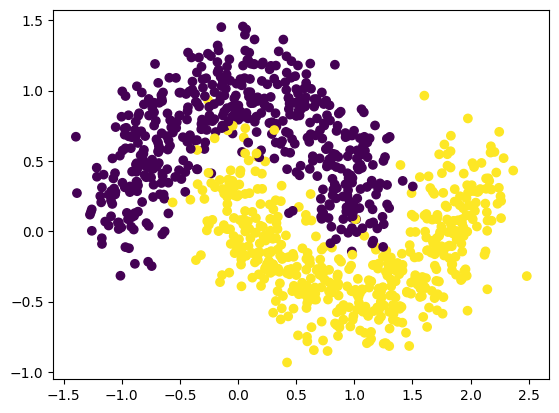

In [5]:
X, y = make_moons(n_samples=1000, noise=0.2, shuffle=True)
train_X, train_y = X[:800], y[:800]
test_X, test_y = X[800:], y[800:]

train_dataset = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).long())
test_dataset = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_y).long())

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Plot the Two Moon dataset
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

We will use an imported model, `TwoMoonsModel` that contains 3 fully connected layers separated by two dropout layers.

In [6]:
dropout_model = TwoMoonsModel()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(dropout_model.parameters(), lr=1e-4, weight_decay=1e-2)
epochs = 100

# Training loop
for i in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optim.zero_grad()

        outputs = dropout_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optim.step()

        running_loss += loss.item()
    if i % 10 == 9:
        print(f'Epoch {i+1} loss: {running_loss}')

Epoch 10 loss: 11.52169644832611
Epoch 20 loss: 8.623343288898468
Epoch 30 loss: 7.446933001279831
Epoch 40 loss: 6.829105533659458
Epoch 50 loss: 6.589593663811684
Epoch 60 loss: 6.0913533717393875
Epoch 70 loss: 5.9127743020653725
Epoch 80 loss: 5.643328718841076
Epoch 90 loss: 5.329191219061613
Epoch 100 loss: 5.138776779174805


We can then turn the dropout off to evaluate the model on the test dataset.

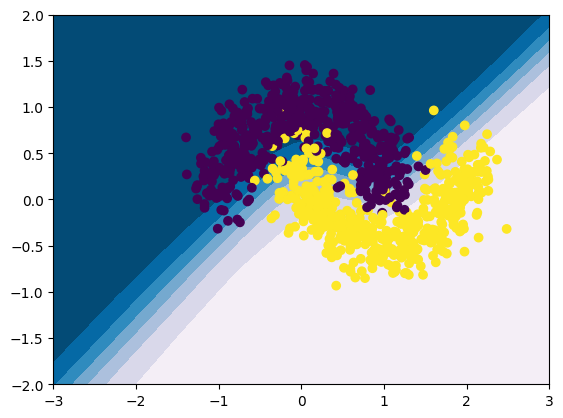

In [39]:
# Turn dropout off
dropout_model.eval()

# Plot the class decision boundary
with torch.no_grad():
    XX, YY = np.meshgrid(np.linspace(-3.0, 3.0, 100), np.linspace(-2.0, 2.0, 100))
    X_tensor = torch.tensor(XX, dtype=torch.float32)
    Y_tensor = torch.tensor(YY, dtype=torch.float32)

    inputs = torch.stack((X_tensor, Y_tensor), dim=2).view(-1, 2)
    outputs = dropout_model(inputs)
    ZZ = outputs.softmax(dim=1)[:,1].reshape((100,100))

    plt.contourf(XX, YY, ZZ, cmap=cm.PuBu_r)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

## Monte Carlo Dropout
Using similar ideas to a normal dropout, Monte Carlo dropout creates a predictive distribution using dropout, but at eval time instead of only during training.

By default, `Dropout` layers are only applied during training, not during testing. In order to run Monte Carlo dropout, during testing we need to enable and sample with the dropout applied.

In [8]:
# Show that the dropout layer is turned off during evaluation
print(nn.Dropout().train()(torch.ones(10))) # output is scaled up during training
print(nn.Dropout().eval()(torch.ones(10)))

tensor([0., 2., 2., 0., 2., 0., 2., 2., 2., 2.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


Once we've trained the model we can turn the dropout layers back on to do Monte Carlo dropout sampling.

Example sample (logits for class 0 and 1):
 tensor([[ 1.1888, -1.3359],
        [ 0.1323, -0.2585],
        [-1.0590,  0.9612],
        [ 1.6019, -1.5981],
        [-1.3235,  0.9678],
        [ 0.9370, -0.8358],
        [-0.4726,  0.4403],
        [-0.4510,  0.4499],
        [-0.9876,  0.6489],
        [ 0.6872, -0.4151]])


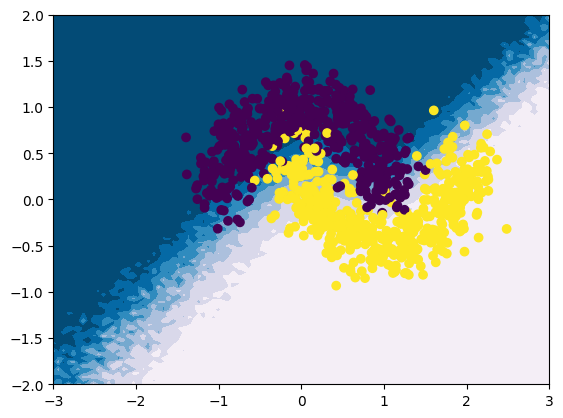

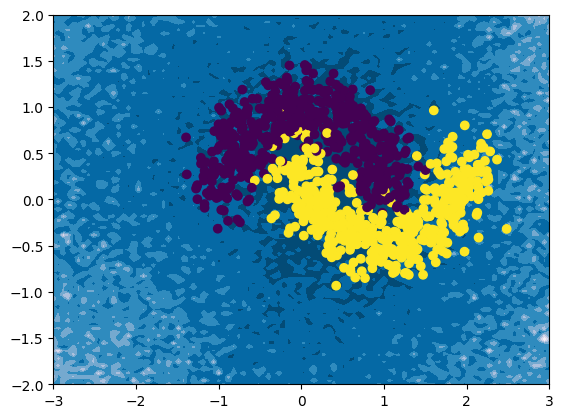

In [41]:
for module in dropout_model.modules():
    if isinstance(module, nn.Dropout):
        module.train()
sample_size = 10

# Plot the class decision boundary
with torch.no_grad():
    XX, YY = np.meshgrid(np.linspace(-3.0, 3.0, 100), np.linspace(-2.0, 2.0, 100))
    X_tensor = torch.tensor(XX, dtype=torch.float32)
    Y_tensor = torch.tensor(YY, dtype=torch.float32)

    inputs = torch.stack((X_tensor, Y_tensor), dim=2).view(-1, 2)
    samples = []
    for i in range(sample_size):
        samples += [dropout_model(inputs)]
    outputs = torch.stack(samples, dim=1)
    print("Example sample (logits for class 0 and 1):\n", outputs[0]) # show one the sample
    mean_outputs = outputs.mean(dim=1).softmax(dim=1)[:, 1]
    std_outputs = outputs.softmax(dim=1).std(dim=1).max(dim=1).values
    ZZ_mean = mean_outputs.reshape((100,100))
    ZZ_std = std_outputs.reshape((100,100))

    plt.contourf(XX, YY, ZZ_mean, cmap=cm.PuBu_r)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

    plt.contourf(XX, YY, ZZ_std, cmap=cm.PuBu_r)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

As we can see from the above, the decision line is largely the same if noisier, but the standard deviation increases the further from the dataset we are.

## Using PusH for Multi Monte Carlo Dropout
Monte Carlo dropout can be sampled over multiple independently trained models to create a Multi Monte Carlo dropout distribution. This can be done using a custom `PusH` distribution or through the `MCDropout` class more easily. Here we will show an example of using multi MC dropout with `PusH` and a `Two Moons` dataset.

In [10]:
# train the model
loss_fn = nn.CrossEntropyLoss()
epochs = 1000
results: torch.Tensor
if __name__ == '__main__':
    mc_dropout = MultiMCDropout.train_mc_dropout(train_dataloader, loss_fn, 50, TwoMoonsModel, patch=True, size_ensemble=3)
    results = mc_dropout.posterior_pred(test_dataloader, num_samples=3)

100%|██████████| 50/50 [00:16<00:00,  3.06it/s]
